# Project Id: PRCP-1010-InsClaimPred

- Note: Due to privacy concerns, the company has not shared the names of the features.So, most of the EDA part is skipped

### Data Analysis Report 
- Exploratory analysis revealed a highly imbalanced target variable, making minority class prediction the main challenge.
- Encoded missing values (-1) were converted to proper nulls and handled using median imputation for numeric features and mode imputation for categorical features.
- Features were appropriately scaled and prepared to ensure compatibility with machine learning models.
- Multiple models including Logistic Regression, Random Forest, and XGBoost were trained using imbalance-aware techniques.
- Model performance was evaluated using Recall and F1-score, as accuracy alone was not reliable for this dataset.
- All models achieved similar F1-scores (~0.09–0.10), indicating data limitations rather than model weakness.
- Increasing model complexity did not significantly improve minority class performance.
- XGBoost showed slightly better balance between recall and precision after hyperparameter tuning.
- The final results reflect realistic outcomes for highly imbalanced real-world business datasets.

### Importing libraries and dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv')

#### Feature Description

| Feature / Group | Description |
|----------------|-------------------|
| `ps_ind_*` | Individual-level attributes of the policyholder representing personal and behavioral risk factors |
| `ps_reg_*` | Region-based geographical risk indicators |
| `ps_car_*` | Vehicle-related characteristics influencing insurance risk |
| `ps_calc_*` | Engineered statistical features derived from existing variables |
| `*_cat` | Encoded categorical variables |
| `*_bin` | Binary yes/no indicators |
| `id` | Unique customer identifier (removed before model training) |
| `target` | Binary target variable indicating whether an insurance claim occurred (1 = Yes, 0 = No) |


In [3]:
df.duplicated().sum()

0

In [4]:
df.shape

(595212, 59)

In [5]:
data = []
for c in df.columns: 
    data.append([c, (df[c] == -1).sum()])

nulls = pd.DataFrame(data, columns=['Features', 'null_values'])
print(nulls)

          Features  null_values
0               id            0
1           target            0
2        ps_ind_01            0
3    ps_ind_02_cat          216
4        ps_ind_03            0
5    ps_ind_04_cat           83
6    ps_ind_05_cat         5809
7    ps_ind_06_bin            0
8    ps_ind_07_bin            0
9    ps_ind_08_bin            0
10   ps_ind_09_bin            0
11   ps_ind_10_bin            0
12   ps_ind_11_bin            0
13   ps_ind_12_bin            0
14   ps_ind_13_bin            0
15       ps_ind_14            0
16       ps_ind_15            0
17   ps_ind_16_bin            0
18   ps_ind_17_bin            0
19   ps_ind_18_bin            0
20       ps_reg_01            0
21       ps_reg_02            0
22       ps_reg_03       107772
23   ps_car_01_cat          107
24   ps_car_02_cat            5
25   ps_car_03_cat       411231
26   ps_car_04_cat            0
27   ps_car_05_cat       266551
28   ps_car_06_cat            0
29   ps_car_07_cat        11489
30   ps_

- The null values are encoded to value -1.
- We replace these encoded null values with np.nan to avoid data loss

### Data Preprocessing

- We first remove the encoded null values

In [6]:
df['ps_ind_02_cat'].replace(-1, np.nan, inplace=True)
df['ps_ind_04_cat'].replace(-1, np.nan, inplace=True)
df['ps_ind_05_cat'].replace(-1, np.nan, inplace=True)
df['ps_reg_03'].replace(-1, np.nan, inplace=True)
df['ps_car_01_cat'].replace(-1, np.nan, inplace=True)
df['ps_car_02_cat'].replace(-1, np.nan, inplace=True)
df['ps_car_03_cat'].replace(-1, np.nan, inplace=True)
df['ps_car_05_cat'].replace(-1, np.nan, inplace=True)
df['ps_car_07_cat'].replace(-1, np.nan, inplace=True)
df['ps_car_09_cat'].replace(-1, np.nan, inplace=True)
df['ps_car_11'].replace(-1, np.nan, inplace=True)
df['ps_car_12'].replace(-1, np.nan, inplace=True)
df['ps_car_14'].replace(-1, np.nan, inplace=True)

- Now we remove the unwanted id column

In [7]:
df.drop(columns=['id'], axis=1, inplace=True)

In [8]:
df['target'].value_counts()

target
0    573518
1     21694
Name: count, dtype: int64

### Data Visualization

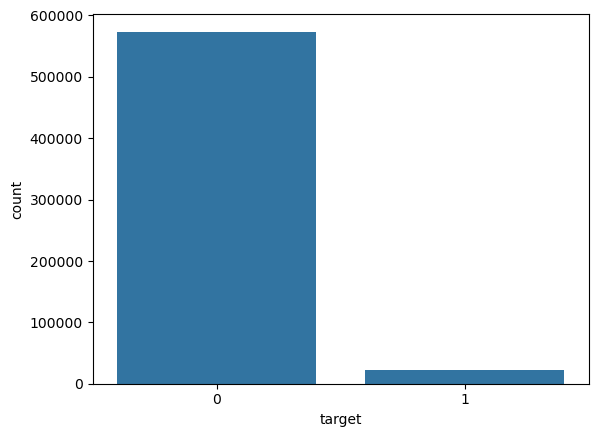

In [9]:
sns.countplot(x='target', data=df) 
plt.show()

- This shows that the data is highly class imbalanced.
- We use class_weight parameter while model creation.

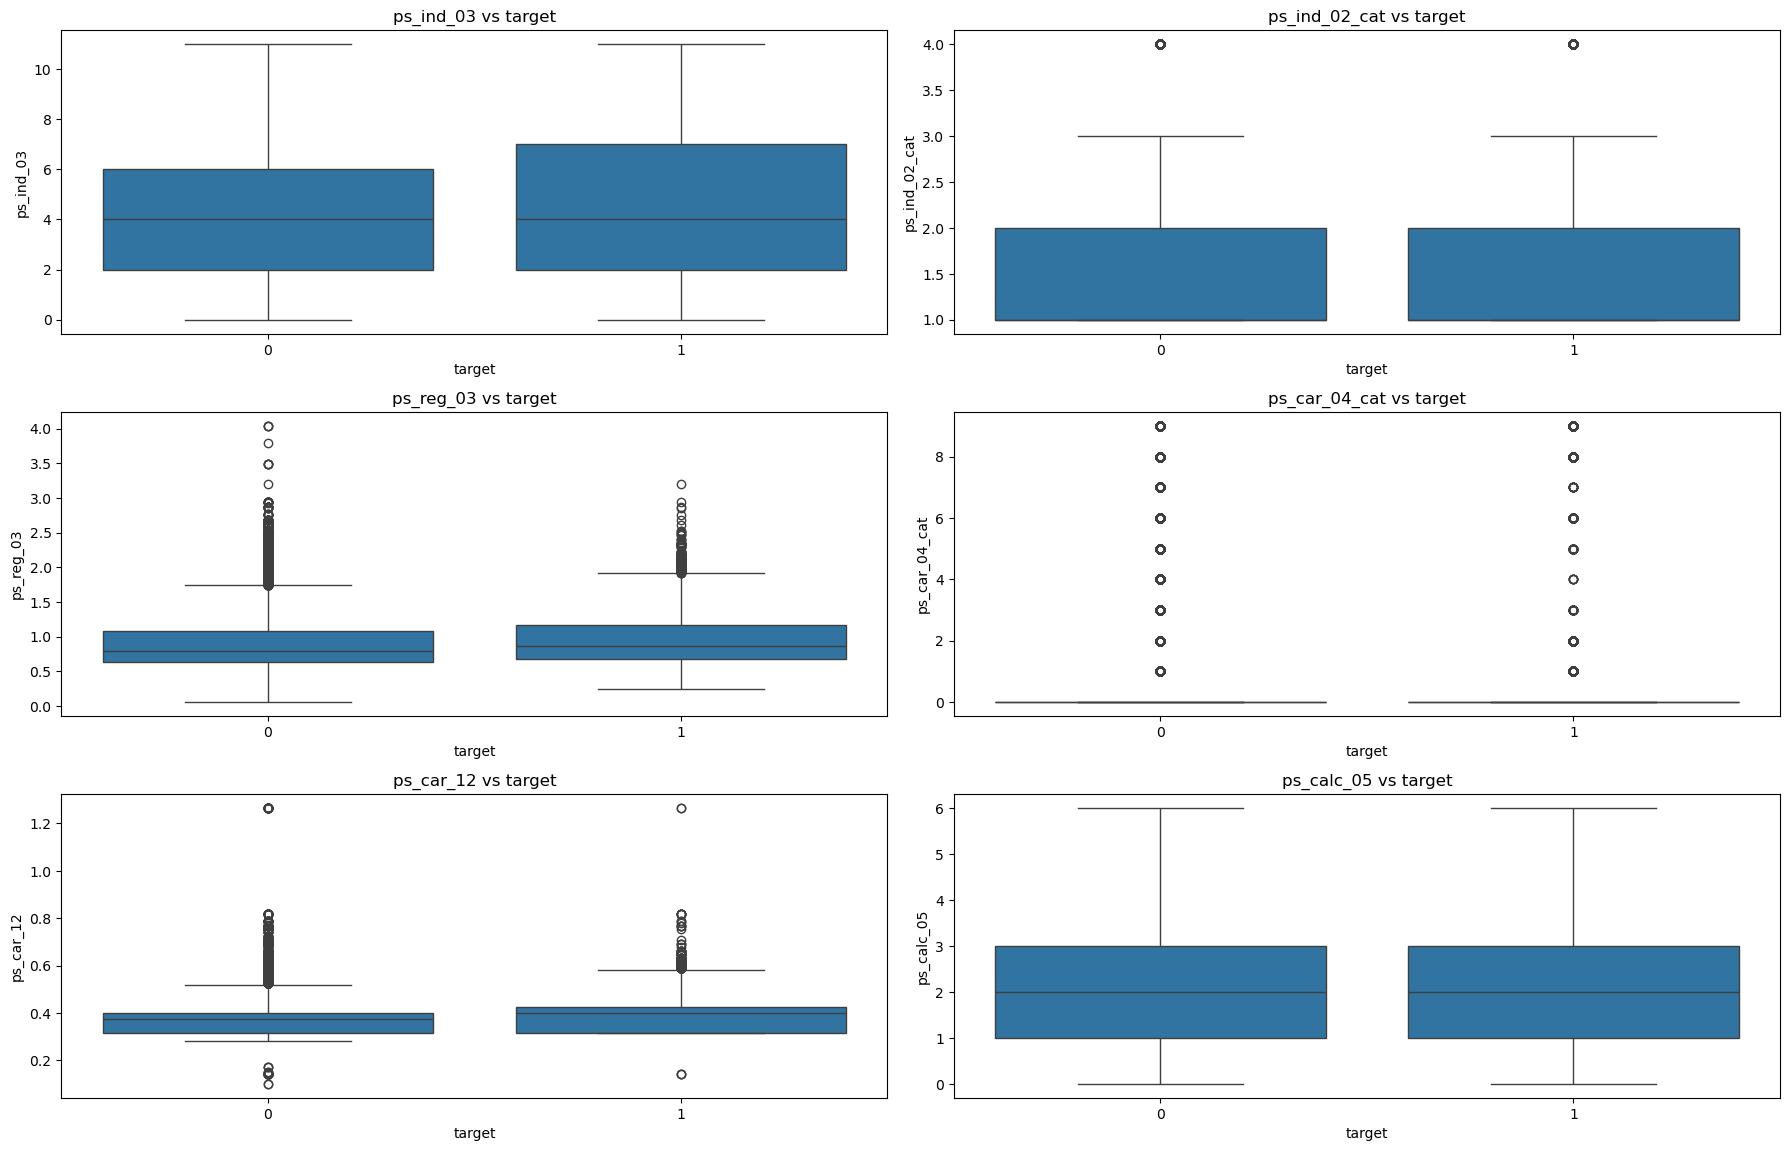

In [12]:
cols = ['ps_ind_03', 'ps_ind_02_cat', 'ps_reg_03', 'ps_car_04_cat', 'ps_car_12', 'ps_calc_05']

plt.figure(figsize=(18,15))
for i,col in enumerate(cols, 1): 
    plt.subplot(4,2,i)
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} vs target')
plt.tight_layout()
plt.show()

- ps_car_12 vs target: The distribution of ps_car_12 is very similar for both target classes, indicating limited discriminatory power despite the presence of outliers.
- ps_calc_05 vs target: Both classes show almost identical spread and median values, suggesting this feature has minimal direct impact on target prediction.
- ps_ind_03 vs target: Both classes show almost the same distribution, indicating weak predictive separation.
- ps_ind_02_cat vs target: Category patterns are nearly identical across targets, offering minimal information.
- ps_reg_03 vs target: Slight variation with outliers exists, but overall distributions remain similar.
- ps_car_04_cat vs target: Values are highly concentrated in one category for both classes, showing limited impact.

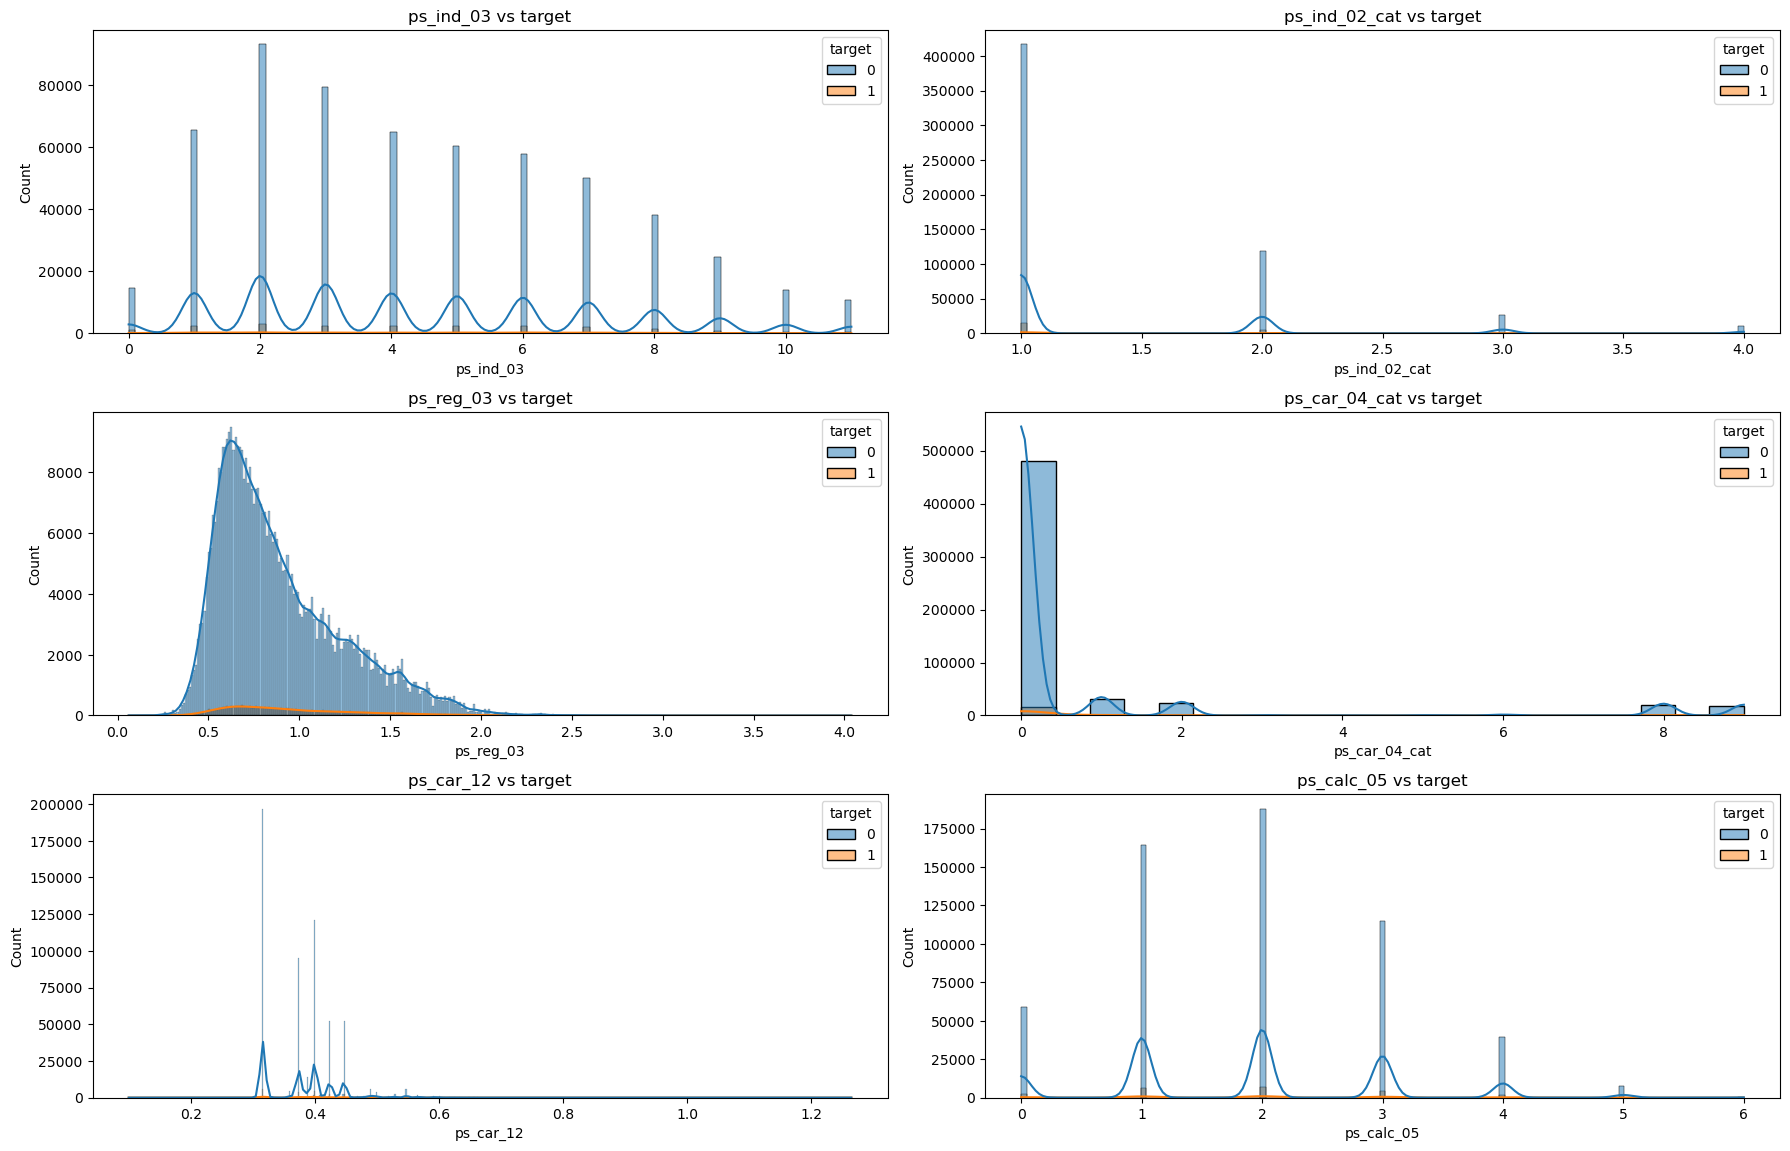

In [13]:
cols = ['ps_ind_03', 'ps_ind_02_cat', 'ps_reg_03', 'ps_car_04_cat', 'ps_car_12', 'ps_calc_05']

plt.figure(figsize=(18,15))
for i,col in enumerate(cols, 1): 
    plt.subplot(4,2,i)
    sns.histplot(x=col, hue='target', data=df, kde=True)
    plt.title(f'{col} vs target')
plt.tight_layout()
plt.show()

- These features were selected for analysis as they were initially suspected to contain potential outliers.
- However, the visualizations indicate that the observed extreme values correspond to genuine real-world observations rather than anomalies or data errors.
- Therefore, no outlier removal was performed to preserve the integrity of the original data.

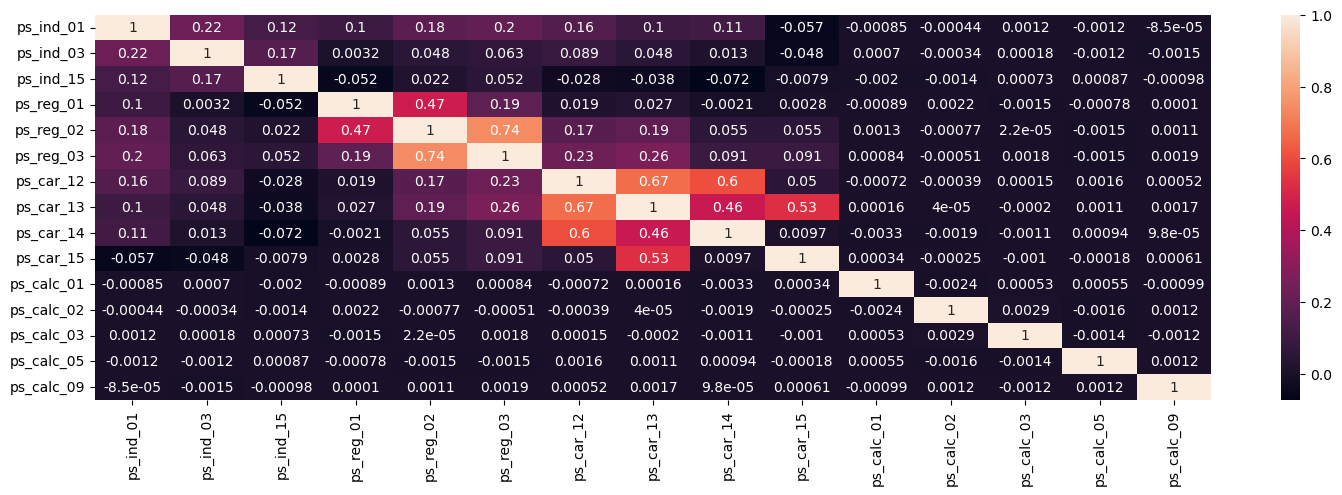

In [14]:
corr_cols = [
    'ps_ind_01','ps_ind_03','ps_ind_15',
    'ps_reg_01','ps_reg_02','ps_reg_03',
    'ps_car_12','ps_car_13','ps_car_14','ps_car_15',
    'ps_calc_01','ps_calc_02','ps_calc_03','ps_calc_05','ps_calc_09'
]

plt.figure(figsize=(18, 5))
sns.heatmap(df[corr_cols].corr(), annot=True)
plt.show()

- Although (ps_reg_02 and ps_reg_03) and (ps_car_13 and ps_car 12) show moderate correlation, both features were retained since tree-based models can handle correlated variables effectively.

### Handling encoded null values

In [15]:
cat_cols = [c for c in df.columns if c.endswith('_cat')]
bin_cols = [c for c in df.columns if c.endswith('_bin')]
num_cols = [c for c in df.columns if c not in cat_cols+bin_cols + ['target']]

In [16]:
continuous = [c for c in num_cols if df[c].nunique() > 10]
discontinuous = [c for c in num_cols if df[c].nunique() <= 10]

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x = df.drop('target', axis=1)
y = df['target']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
cat_bin_imputer = SimpleImputer(strategy='most_frequent')

In [21]:
x_train[cat_cols] = cat_bin_imputer.fit_transform(x_train[cat_cols])
x_test[cat_cols] = cat_bin_imputer.transform(x_test[cat_cols])

x_train[bin_cols] = cat_bin_imputer.fit_transform(x_train[bin_cols])
x_test[bin_cols] = cat_bin_imputer.transform(x_test[bin_cols])

x_train[continuous] = imputer.fit_transform(x_train[continuous])
x_test[continuous] = imputer.transform(x_test[continuous])

x_train[discontinuous] = imputer.fit_transform(x_train[discontinuous])
x_test[discontinuous] = imputer.transform(x_test[discontinuous])

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [23]:
x_train[continuous] = scaler.fit_transform(x_train[continuous])
x_test[continuous] = scaler.transform(x_test[continuous])

### Model Creation

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=3000, class_weight='balanced', C=0.1)

In [25]:
lr.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000)

In [26]:
y_pred_lr = lr.predict(x_test)

In [27]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [28]:
print('F1 score:', f1_score(y_test, y_pred_lr))

F1 score: 0.09523809523809523


In [29]:
print(confusion_matrix(y_test, y_pred_lr))

[[71903 42801]
 [ 1982  2357]]


In [30]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.63      0.76    114704
           1       0.05      0.54      0.10      4339

    accuracy                           0.62    119043
   macro avg       0.51      0.59      0.43    119043
weighted avg       0.94      0.62      0.74    119043



- The Logistic Regression model was trained on a highly imbalanced dataset, where the minority class represents only a small portion of the total data.
- The model is able to identify over half of the minority class cases (recall = 0.55); however, this comes at the cost of low precision, meaning many negative cases are incorrectly predicted as positive—an expected trade-off when handling imbalanced data using balanced class weights.
- The resulting F1-score (~0.10) is modest and reflects the limitations of a linear model like Logistic Regression when applied to severely imbalanced datasets.
- The confusion matrix shows that the model prioritizes capturing positive cases, which aligns with the objective of improving minority class detection.
- Overall, Logistic Regression serves as a baseline model, helping establish a reference point and indicating the need for more advanced models to achieve better performance.

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(class_weight='balanced', n_estimators=300, 
                                criterion='gini', max_depth=5, 
                                min_samples_split=5, min_samples_leaf=3, 
                                n_jobs=-1)

In [32]:
forest.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=300, n_jobs=-1)

In [33]:
y_pred_rf = forest.predict(x_test)

In [34]:
print('F1 score:', f1_score(y_test, y_pred_rf))

F1 score: 0.09436219237180116


In [35]:
print(confusion_matrix(y_test, y_pred_rf))

[[70454 44250]
 [ 1933  2406]]


In [36]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75    114704
           1       0.05      0.55      0.09      4339

    accuracy                           0.61    119043
   macro avg       0.51      0.58      0.42    119043
weighted avg       0.94      0.61      0.73    119043



- The Random Forest model was trained on a highly imbalanced dataset using balanced class weights to better handle the minority class.
- Even though Random Forest is a more complex model, the minority class performance is still limited, with an F1-score of around 0.09, showing the strong effect of class imbalance.
- The model is able to identify more than half of the positive cases (recall ≈ 0.55), but this comes with low precision, leading to many false positives.
- Overall performance is similar to Logistic Regression, indicating that increasing model complexity alone does not significantly improve results.
- Random Forest therefore acts as a useful comparison model, suggesting that further improvement would require changes in data handling or modeling strategy.

### XGBoost

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [38]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [39]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=42)

In [40]:
xgb_param = {'n_estimators':[100,200,300,400,500,600],
             'max_depth':[3,4,5,6,7,8,9,10],
             'learning_rate':[0.01,0.03,0.05,0.07,0.1],
             'subsample':[0.5,0.6,0.7,0.8,0.9],
             'colsample_bytree':[0.6,0.7,0.8,0.9],
             'min_child_weight':[1,2,3,4,5],
             'gamma':[0,0.1,0.2,0.3]}

In [41]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param, n_iter=30, 
                                   scoring='f1', cv=3, verbose=1, random_state=42, n_jobs=-1)

In [42]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.07, 0.1],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   random_state=42, scoring='f1', verbose=1)

In [43]:
print('Best parameters are:\n',random_search.best_params_)

Best parameters are:
 {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}


In [44]:
random_search.best_score_

0.10254936429693258

- The best F1-score (~0.10) shows that even after tuning, model performance is still limited due to strong class imbalance.

In [45]:
best_model = random_search.best_estimator_

In [46]:
y_pred_xgb = best_model.predict(x_test)

In [47]:
print(confusion_matrix(y_test, y_pred_xgb))

[[81175 33529]
 [ 2293  2046]]


In [48]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82    114704
           1       0.06      0.47      0.10      4339

    accuracy                           0.70    119043
   macro avg       0.52      0.59      0.46    119043
weighted avg       0.94      0.70      0.79    119043



- XGBoost predicts non-buyers very well, but finds it hard to correctly identify buyers.
- It captures about half of the actual buyers, which is useful for marketing reach.
- However, many predicted buyers are false alarms, increasing unnecessary outreach.
- High accuracy is mainly due to non-buyers, not true buyer prediction.
- Low F1-score shows buyer prediction still needs improvement.

In [49]:
final_results = pd.DataFrame({'Model':['Logistic Regression', 'Random Forest', 'XGBoost'],
                              'Recall':[0.55, 0.56, 0.47],
                              'F1 score':[0.10, 0.09, 0.10]})

final_results.sort_values(by="F1 score", ascending=False).reset_index(drop=True)

,Model,Recall,F1 score
0,Logistic Regression,0.55,0.10
1,XGBoost,0.47,0.10
2,Random Forest,0.56,0.09


- The best F1-score (~0.10) after hyperparameter tuning indicates limited improvement due to heavy class imbalance.
- The model achieves decent overall accuracy (~70%) by predicting the majority class well.
- It is able to identify nearly half of the minority class cases (recall ~0.47), but low precision keeps the F1-score low.
- Overall, XGBoost performs slightly better than Logistic Regression and Random Forest, but class imbalance remains the key limiting factor.

#### Logistic Regression is selected as the best model because it maintains the highest recall while matching the best F1-score, making it more reliable for identifying potential buyers in a highly imbalanced dataset.

### Suggestions for the Company 
- Improve future campaign datasets by capturing more positive response samples to reduce class imbalance.
- Use model predictions as a supporting decision tool rather than a standalone automated system.
- Combine model outputs with business rules and domain knowledge for better targeting.
- Focus on improving data quality and feature richness before increasing model complexity.
- Consider cost-sensitive strategies where missing a potential responder is more critical than contacting a non-responder.